# Spotify Playlist Personalisation

----

### 1. Set Environmental variables

Use auth_example.env as a sample. Provide all 3 secrets set in your spotify developer platform

* SPOTIFY_CLIENT_ID=
* SPOTIFY_CLIENT_SECRET=
* SPOTIFY_REDIRECT_URI=


In [1]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()


True

### 2. Generate Token
Provide call back link to generate token for use

In [2]:
import tekore as tk
conf = tk.config_from_environment()
token = tk.prompt_for_user_token(*conf)


Opening browser for Spotify login...


### 3. Retrieving Playlist & Track Data

Reference util.py for additional functionality for data pull.

Utilising tekore package to interact with Spotify API.


In [209]:
import util
import asyncio
import pandas as pd

async_spotify = tk.Spotify(token = token, asynchronous=True)
uri = 'spotify:user:gingerale3'
userID = 'gingerale3'

In [210]:
import importlib
importlib.reload(util)

<module 'util' from 'c:\\Users\\alexc\\spotify-gpt-app\\packages\\experimentation\\util.py'>

In [211]:
a = await fetch_playlists(async_spotify, userID)

In [253]:
playlist_ids = []
for i, playlist in enumerate(a):
    # if playlist.owner.uri != uri:
    #     continue
    playlist_ids.append((playlist.id, playlist.name))

In [255]:
async def get_playlist_tracks_ids(spotify, playlistID: str, playlistName: str):
    playlistTracks = []
    inital_response = await spotify.playlist_items(playlistID, limit = 1, offset = 0)
    total = inital_response.total 
    playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in inital_response.items)
    limit = 50
    numOfCalls = (total - 1)//limit + 1

    tasks = [spotify.playlist_items(playlistID, limit = limit, offset = 1 + limit * i) for i in range(numOfCalls)]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in response.items)

    return playlistTracks


In [256]:
playlistTracks = []
for i in range(len(playlist_ids)//3 + 1):
    tasks = [get_playlist_tracks_ids(async_spotify, id[0], id[1]) for id in playlist_ids[i*3:(i+1)*3]]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend(response)

In [257]:
len(playlistTracks)

3355

In [259]:
# Track id and corresponding playlist
trackId_playlist = []

for tracks in playlistTracks:
    if tracks['track'].track.id is None:
        continue
    trackId_playlist.append({'playlistID': tracks['playlistID'], 'playlistName': tracks['name'], 'id': tracks['track'].track.id})

In [260]:
len(set([(tracks['playlistID'], tracks['track'].track.id)  for tracks in playlistTracks]))

3352

In [306]:
# Get all features for tracks
track_features = await get_tracks_audio_features(async_spotify, tracks = [track['id'] for track in trackId_playlist])
track_features = [track.__dict__ for track in track_features if track is not None]
track_features_df = pd.DataFrame(track_features).drop_duplicates()
df = pd.DataFrame(trackId_playlist).merge(track_features_df, on = 'id', how = 'left')


In [300]:
# Add description playlist descriptions
len(playlist_ids)

31

In [303]:
# Create consolidate dataframe

In [326]:
features = [
    'acousticness', 
    'danceability',
    'energy',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence'
]

df_clean = df.dropna(subset=features)

# ### What if i scaled the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[features] = scaler.fit_transform(df_clean[features])

c:\Users\alexc\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Modelling

In [327]:
df_clean

,playlistID,playlistName,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,2Q7wCNeLOaOmHvQTogMSy2,0.959839,https://api.spotify.com/v1/audio-analysis/2Q7w...,0.715946,124444.0,0.098765,0.883182,1.000000,0.099657,0.349504,1.0,0.048407,0.227492,0.75,https://api.spotify.com/v1/tracks/2Q7wCNeLOaOm...,audio_features,spotify:track:2Q7wCNeLOaOmHvQTogMSy2,0.101734
1,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,2IsAHhoLXp6KXnGaUeL3zB,0.478915,https://api.spotify.com/v1/audio-analysis/2IsA...,0.708269,128000.0,0.056714,0.926485,0.181818,0.101869,0.327711,0.0,0.019848,0.443365,0.75,https://api.spotify.com/v1/tracks/2IsAHhoLXp6K...,audio_features,spotify:track:2IsAHhoLXp6KXnGaUeL3zB,0.110090
2,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,3FxNrEMsJUI9T0exSfdDwb,0.858433,https://api.spotify.com/v1/audio-analysis/3FxN...,0.566791,129065.0,0.081001,0.935549,0.545455,0.110718,0.416651,0.0,0.035065,0.163735,0.75,https://api.spotify.com/v1/tracks/3FxNrEMsJUI9...,audio_features,spotify:track:3FxNrEMsJUI9T0exSfdDwb,0.045749
3,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,4g9NKHADC5JzjHayUjwUdG,0.979920,https://api.spotify.com/v1/audio-analysis/4g9N...,0.713753,132923.0,0.081402,0.966767,0.000000,0.084393,0.411819,1.0,0.039916,0.498839,0.75,https://api.spotify.com/v1/tracks/4g9NKHADC5Jz...,audio_features,spotify:track:4g9NKHADC5JzjHayUjwUdG,0.145603
4,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,7h3f29Vi8uuMJAQGEvzhgT,0.955823,https://api.spotify.com/v1/audio-analysis/7h3f...,0.663303,118182.0,0.040756,0.955690,0.363636,0.104081,0.466932,0.0,0.011027,0.509637,0.75,https://api.spotify.com/v1/tracks/7h3f29Vi8uuM...,audio_features,spotify:track:7h3f29Vi8uuMJAQGEvzhgT,0.087111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,3AraBEre6TrHoClhG3EqCE,0.384537,https://api.spotify.com/v1/audio-analysis/3Ara...,0.368283,178787.0,0.634689,0.000000,0.363636,0.275523,0.813246,0.0,0.017973,0.481969,0.75,https://api.spotify.com/v1/tracks/3AraBEre6TrH...,audio_features,spotify:track:3AraBEre6TrHoClhG3EqCE,0.296010
3350,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,1MSM3Fo2fvnwVqMcz8Jhjq,0.013151,https://api.spotify.com/v1/audio-analysis/1MSM...,0.351832,223880.0,0.844442,0.000000,0.454545,0.327508,0.767197,1.0,0.133311,0.853268,0.75,https://api.spotify.com/v1/tracks/1MSM3Fo2fvnw...,audio_features,spotify:track:1MSM3Fo2fvnwVqMcz8Jhjq,0.227073
3351,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,6W4GTXLYX8HkmZGmVkfrSC,0.582329,https://api.spotify.com/v1/audio-analysis/6W4G...,0.590919,245960.0,0.698919,0.277946,0.090909,0.095233,0.752511,0.0,0.084794,0.448429,0.75,https://api.spotify.com/v1/tracks/6W4GTXLYX8Hk...,audio_features,spotify:track:6W4GTXLYX8HkmZGmVkfrSC,0.286610
3352,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,6MByWSkfqebVmpPw3pA1uR,0.020179,https://api.spotify.com/v1/audio-analysis/6MBy...,0.681948,186440.0,0.680854,0.016314,0.181818,0.087490,0.820510,1.0,0.006616,0.393637,0.75,https://api.spotify.com/v1/tracks/6MByWSkfqebV...,audio_features,spotify:track:6MByWSkfqebVmpPw3pA1uR,0.580113


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3353 samples in 0.006s...
[t-SNE] Computed neighbors for 3353 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3353
[t-SNE] Computed conditional probabilities for sample 2000 / 3353
[t-SNE] Computed conditional probabilities for sample 3000 / 3353
[t-SNE] Computed conditional probabilities for sample 3353 / 3353
[t-SNE] Mean sigma: 0.191020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.323875
[t-SNE] KL divergence after 300 iterations: 1.596639


<ipython-input-328-3c8b37d658a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-one'] = tsne_results[:,0]
<ipython-input-328-3c8b37d658a6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tsne-2d-two'] = tsne_results[:,1]


Text(0, 0.5, 'tsne-2d-two')

c:\Users\alexc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 55358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\alexc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 56589 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\alexc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 55358 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\alexc\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 56589 missing from current font.
  font.set_text(s, 0, flags=flags)


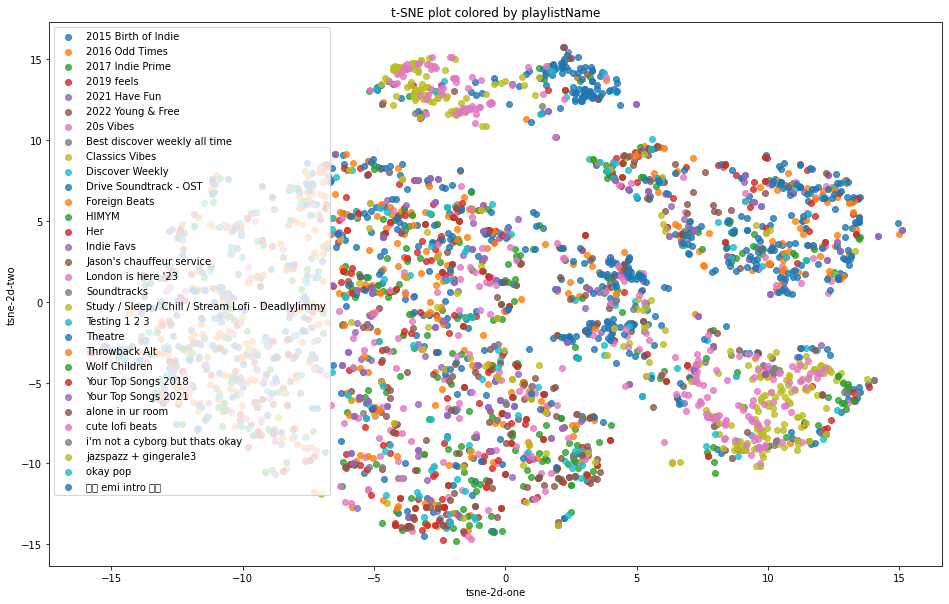

In [328]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the features from the dataframe
data_subset = df_clean[features].values

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

# Add the t-SNE results back into the dataframe
df_clean['tsne-2d-one'] = tsne_results[:,0]
df_clean['tsne-2d-two'] = tsne_results[:,1]

# Create a plot
plt.figure(figsize=(16,10))

# Scatter plot for each playlist
for playlist, group in df_clean.groupby('playlistName'):
    plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist)

plt.legend()
plt.title('t-SNE plot colored by playlistName')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')


In [329]:
playlist_ids

[('4yo2GyYfzYHT6aUIwsYaKC',
  'Study / Sleep / Chill / Stream Lofi - DeadlyJimmy'),
 ('6FW6zNPqi1p4TAGQAdd1ZN', 'Theatre'),
 ('1CnAtW2mIejhmERcoQN9Yx', 'Drive Soundtrack - OST'),
 ('1M14Pc0M9RCNTeiGZYkRos', "London is here '23"),
 ('7KeBns6uk8vGdzUa6O1a33', 'cute lofi beats'),
 ('02LdkmiBoGlXsY2I1ih9US', "Jason's chauffeur service"),
 ('0Vk4MDyopj4i5CKDRyAfj0', 'alone in ur room'),
 ('6MrVz9LUs9BAXKEIHzYVtR', '🤍 emi intro 🤍'),
 ('5oa8MOiooDE7fOcPS8CZUt', "i'm not a cyborg but thats okay"),
 ('03BSiGHJkX7SG23dOYlgoJ', '2022 Young & Free'),
 ('37i9dQZF1EUMDoJuT8yJsl', 'Your Top Songs 2021'),
 ('0owDaOLnhuRaxuzClvLGEP', 'Her'),
 ('37i9dQZF1EJxsvxyG07Are', 'jazspazz + gingerale3'),
 ('5Pv2gzBYYbUDJp2YYkVByu', 'Best discover weekly all time'),
 ('2sSdZCcMsDoZ9vXp5tYJhL', '2021 Have Fun'),
 ('6m9b4dHTu8ts9lwoX5nKxg', 'HIMYM'),
 ('59X5BMQrTC9N02wAcQyXzo', 'Soundtracks'),
 ('7yapFMoqWw9bzFk1UjJwEP', '20s Vibes'),
 ('5cwJ8MHnOyk6wRM5WTRF8b', 'okay pop'),
 ('37i9dQZF1EjwW6brYaSN6M', 'Your Top So

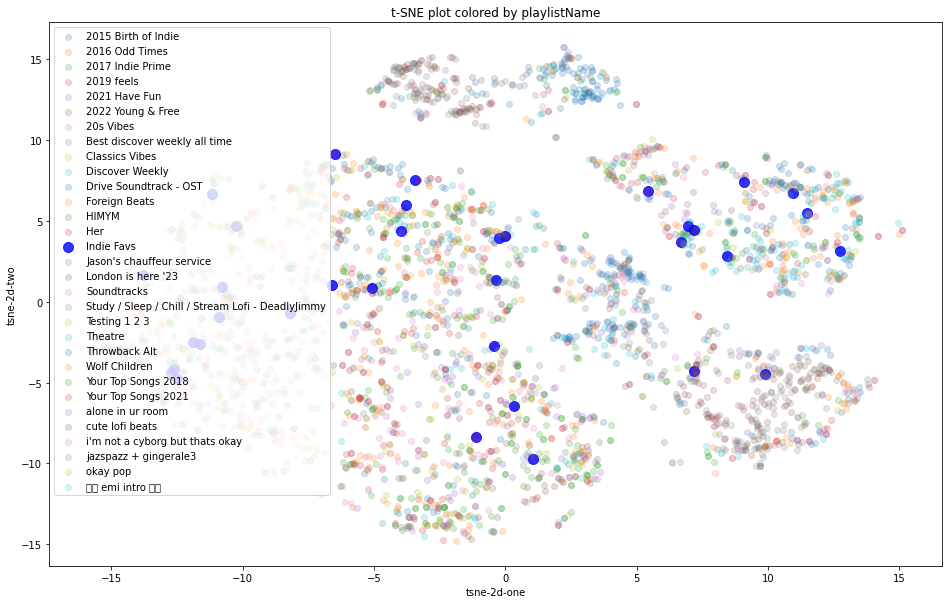

In [340]:
plt.figure(figsize=(16,10))

# Scatter plot for each playlist
for playlist, group in df_clean.groupby('playlistName'):
    if playlist == "Indie Favs": #jazspazz + gingerale3 jason's chauffeur service
        plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist, color='blue', s=100)  # Change color and size
    else:
        plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.2, label=playlist)

plt.legend()
plt.title('t-SNE plot colored by playlistName')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')

plt.show()
